## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [227]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

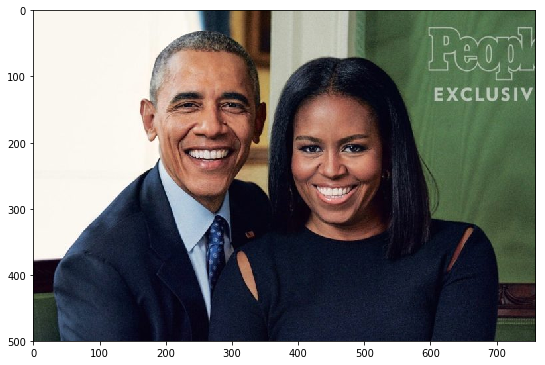

In [228]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


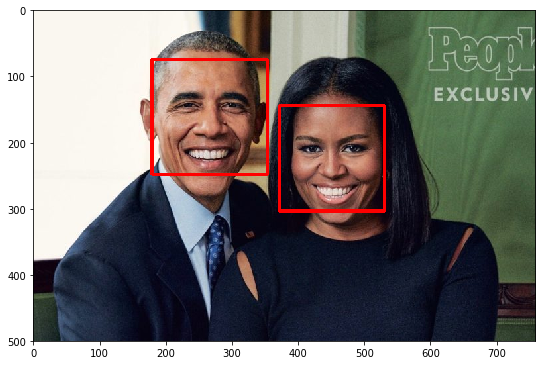

In [229]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [230]:
import torch
from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout3): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (dropout4): Dropout(p=0.4)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (dropout5): Dropout(p=0.5)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (dropout6): Dropout(p=0.6)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




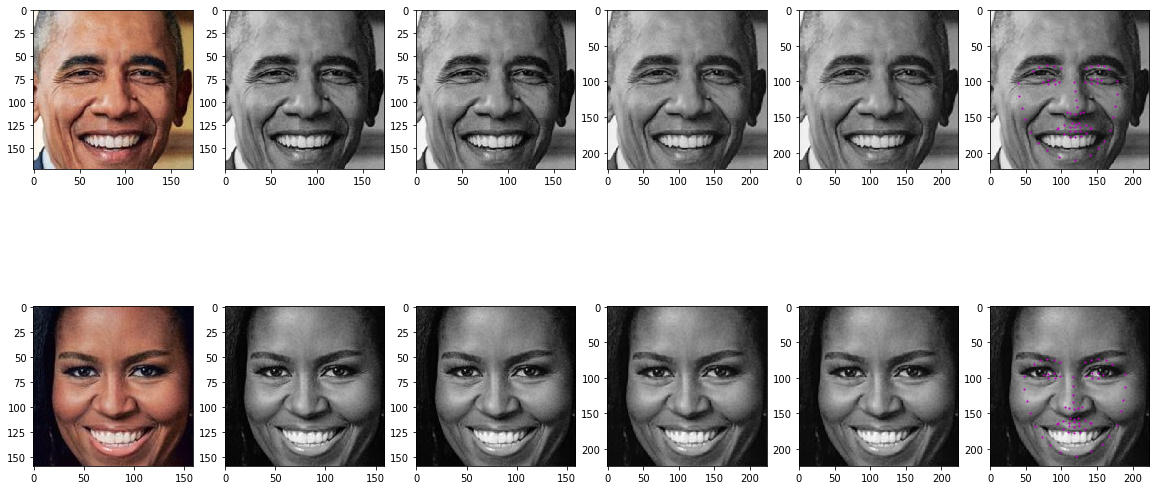

In [251]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
all_transformed_images = []
for (x,y,w,h) in faces:
    transformed_images = []
    # Select the region of interest that is the face in the image 
    roi = image_copy.copy()[y:y+h, x:x+w]
    # 0
    transformed_images.append(roi)

    # 1
    ## TODO: Convert the face region from RGB to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    transformed_images.append(gray)
    
    # 2
    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    normalized = gray / 255.0
    transformed_images.append(normalized)
    
    # 3
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    scaled = cv2.resize(normalized, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    transformed_images.append(scaled)
    
    # 4
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    reshaped = scaled.reshape(1, scaled.shape[0], scaled.shape[1])
    transformed_images.append(reshaped.reshape(224, 224))

    # 5
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    ## perform a forward pass to get the predicted facial keypoints
    predicted = net(torch.Tensor(reshaped).reshape(1, 1, 224, 224))
    predicted = predicted.transpose(1, 0).reshape(68, 2) * 50 + 100
    transformed_images.append(predicted.detach().numpy())

    all_transformed_images.append(transformed_images)

#     TODO: Display each detected face and the corresponding keypoints
plt.figure(figsize=(20, 10))
for i, transformed_images in enumerate(all_transformed_images):
    for j, img in enumerate(transformed_images):
#         print(img.shape)
        ax = plt.subplot(len(all_transformed_images), len(transformed_images), len(transformed_images) * i + j + 1)
        if(img.shape[0] == 68):
            ax.imshow(transformed_images[4], cmap='gray')
            plt.scatter(img[:, 0], img[:, 1], s=5, marker='.', c='m')
        else:
            ax.imshow(img, cmap='gray')
plt.show()

        
